### Another example: The SIR epidemic without vital dynamics
https://en.wikipedia.org/wiki/Gillespie_algorithm#Another_example:_The_SIR_epidemic_without_vital_dynamics

The SIR model is a classic biological description of how certain diseases permeate through a fixed-size population. In its simplest form there are $\displaystyle N$ members of the population, whereby each member may be in one of three states -- susceptible, infected, or recovered -- at any instant in time, and each such member transitions irreversibly through these states according to the directed graph below. We can denote the number of susceptible members as $\displaystyle n_{S}$, the number of infected members as $\displaystyle n_{I}$, and the number of recovered members as $\displaystyle n_{R}$. Therefore we may also conclude that $\displaystyle N=n_{S}+n_{I}+n_{R}$ for any point in time.

SIR graph.png
Further, a given susceptible member will transition to the infected state by coming into contact with any of the $\displaystyle n_{I}$ infected members, and so infection occurs with rate $\displaystyle \alpha n_{I}$ (dimensions of inverse time). A given member of the infected state recovers without dependence on any of the three states, which is specified by rate β (also with dimensions of inverse time). Given this basic scheme, it possible to construct the following non-linear system.


A single realization of the SIR epidemic as produced with an implementation of the Gillespie algorithm.
$$
{\displaystyle {\frac {dn_{S}}{dt}}=-{\frac {\alpha n_{S}}{V}}n_{I}},\\
{\displaystyle {\frac {dn_{I}}{dt}}=\left({\frac {\alpha n_{S}}{V}}-\beta \right)n_{I}},\\
{\displaystyle {\frac {dn_{R}}{dt}}=\beta n_{I}}
$$
This system has no analytical solution. However, with the Gillespie algorithm, it can be simulated many times, and a regression technique such as least-squares may be applied to fit a polynomial over all of the trajectories. As the number of trajectories increases, such polynomial regression will asymptotically behave like an analytic solution. In addition to estimating the solution to an intractable problem like the SIR epidemic, the stochastic nature of each trajectory allows one to compute statistics other than $\displaystyle \mathrm {E} [n|t]$.

The trajectory presented in the above figure was simulated with the following Python implementation of the Gillespie algorithm.

In [1]:
import math
import random

# Input parameters ####################

# int; total population
N = 350

# float; maximum elapsed time
T = 100.0

# float; start time
t = 0.0

# float; spatial parameter
V = 100.0

# float; rate of infection after contact
_alpha = 1.0

# float; rate of cure
_beta = 0.5

# int; initial infected population
n_I = 1

#########################################

# Compute susceptible population, set recovered to zero
n_S = N - n_I
n_R = 0

# Initialize results list
SIR_data = []
SIR_data.append((t, n_S, n_I, n_R))

# Main loop
while t < T:
    if n_I == 0:
        break

    w1 = _alpha * n_S * n_I / V
    w2 = _beta * n_I
    W = w1 + w2

    dt = -math.log(random.uniform(0.0, 1.0)) / W
    t = t + dt

    if random.uniform(0.0, 1.0) < w1 / W:
        n_S = n_S - 1
        n_I = n_I + 1
    else:
        n_I = n_I - 1
        n_R = n_R + 1

    SIR_data.append((t, n_S, n_I, n_R))

with open('SIR_data.txt', 'w+') as fp:
    fp.write('\n'.join('%f %i %i %i' % x for x in SIR_data))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(SIR_data)
plt.legend(['t','S','I','R'])
plt.show()

<Figure size 640x480 with 1 Axes>

### Predator-Prey Gillespie

$$
\dot{x}=(a y) x-b x\\
\dot{y}= c y -(d x) y\\
$$

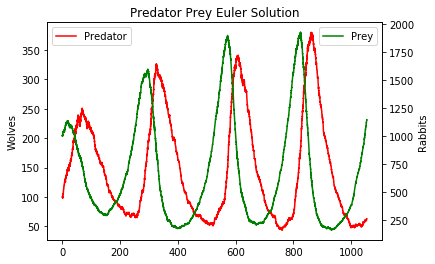

In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

apred = 3e-5   #predator's birth rate
bpred = 2e-2   #predator's death rate
cprey = 3e-2   #prey's birth rate
dprey = 2e-4   #prey's death rate

def x_prime(x):
    return (apred*y)*x - bpred*x   #predator population rate of change

def y_prime(y):
    return cprey*y-(dprey*x)*y   #prey population rate of change

a = 0.0         # Start of the interval
b = 1000.0      # End of the interval
N = 5e4     # Number of steps
h = (b-a)/N     # Size of a single step

i = 0
t = 0.0
x = 100.0       # Initial predator
y = 1000.0      # Initial prey

#create the array of time values and (empty) x-values, and loop over 
#all times supplementing x each time
xpoints = []
ypoints = []
#tpoints = np.arange(a,b,h)
tpoints = []

#Eulerian solver
#for t in tpoints:
#    xpoints.append(x)
#    ypoints.append(y)
#    x += h*x_prime(x)
#    y += h*y_prime(y)
    
# Main loop Gillespie Simulation
#for t in tpoints:
while i < N:
    i=i+1
    
    if x == 0:
        break    
    
    w1 = apred*x*y
    w2 = bpred*x
    w3 = cprey*y
    w4 = dprey*x*y
    W = w1 + w2 + w3 + w4
    
    dt = -math.log(random.uniform(0.0, 1.0)) / W
    #dt = h    
    t = t + dt
    
    r=random.uniform(0.0, 1.0)
    if  r < (w1/W):
        x = x + 1
    elif (w1/W <= r < (w1+w2)/W):
        x = x - 1
    elif ((w1+w2)/W <= r < (w1+w2+w3)/W):
        y = y + 1
    elif ((w1+w2+w3)/W <= r):
        y = y - 1   
    xpoints.append(x)
    ypoints.append(y)
    tpoints.append(t)


plt.plot(tpoints,xpoints, color = 'red' , label='Predator')
plt.legend(loc='upper left')
plt.ylabel("Wolves")
plt.twinx()
plt.plot(tpoints,ypoints, color = 'green' , label='Prey')
plt.legend(loc='upper right')
plt.ylabel("Rabbits")

plt.title("Predator Prey Euler Solution")
plt.xlabel("Years")
plt.show()

### HANDY Gillespie

$$
\dot{x}=\beta x - \alpha x\\
\dot{y}=\gamma y (\lambda-y) - \delta x y \\
\dot{w}=\delta x y - C \\
$$

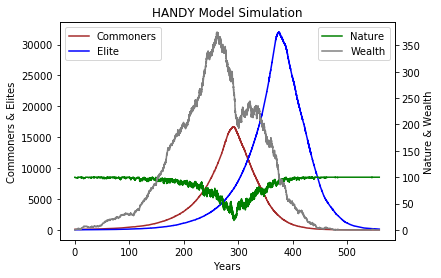

In [26]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

alph_m = 1.0e-2
alph_max = 7.0e-2
beta_c = 6.5e-2
beta_e = 2.0e-2
s = 5.0e-4
rho = 5.0e-3
gam = 1.0e-2
lam = 100
kap = 10 # 1, 10, 100
del_ = 1.e-5 #No typical value

beta_c = 3.e-2
beta_e = 3.e-2
del_ = 36.67e-6 #No typical value

chi_cnot = 100
chi_enot = 25 # 0, 1, 25
chi_c = chi_cnot  #I'm not quite sure how to deal with this specific condition
chi_e = chi_enot
w = 0.01          # Initial condition
y = lam           # Initial condition

def xp_c(chi_c):
    return (beta_c - alph_c)*chi_c
def xp_e(chi_e):
    return (beta_e - alph_e)*chi_e
def yp(y,chi_c):
    return (gam*(lam-y)-del_*chi_c)*y
def wp(chi_c):
    return del_*chi_c*y-c_c-c_e  #this function doesn't have the variable "w" in it explicitly: FIX

i = 0
t = 0.0
a = 0.0         # Start of the interval
b = 1000.0      # End of the interval
N = 1.e6        # Number of steps
h = (b-a)/N     # Size of a single step

#create the array of time values and (empty) x-values, and loop over 
#all times supplementing x each time
#tpoints = np.arange(a,b,h)
tpoints = []
chi_cpts = []
chi_epts = []
ypts = []
wpts = []

#for t in tpoints:
while i < N:
    i=i+1
    if chi_e == 0:
        break    
    if chi_c == 0:
        break    

    chi_cpts.append(chi_c)
    chi_epts.append(chi_e)
    ypts.append(y)
    wpts.append(w)
    tpoints.append(t)
    
    #variables and equations
    w_th = rho*(chi_c + kap*chi_e)
    omega = w/(w_th)
    c_c = min(1, omega)*s*chi_c  #TO DO: figure out what min() means...
    c_e = min(1, omega)*kap*s*chi_e  #TO DO: ^same
    alpha_c = alph_m + max(0, 1-c_c/(s*chi_c))*(alph_max - alph_m)  #TO DO: ^same
    alpha_e = alph_m + max(0, 1-c_e/(s*chi_e))*(alph_max - alph_m)  #TO DO: ^same
    eta = (alph_max - beta_c)/(alph_max - alph_m)
    chi = gam/(del_)*(lam-eta*s/del_)
    egal_opt = 2*eta*s/(lam)
    chi_m = gam*lam/(2*egal_opt) #or (gam*(lam/2)^2)/(eta*s)
    phi = chi_enot/(chi_cnot)
    equi_opt = 2*eta*s*(1 + phi)/(lam)
    psy = chi_e/(chi_c)
    uneq_opt = 2*eta*s*(1 + kap*psy)/(lam)

    #chi_c += h*xp_c(chi_c)
    #chi_e += h*xp_e(chi_e)
    #y += h*yp(y,chi_c)
    #w += h*wp(chi_c)

    w1 = (chi_c*beta_c)
    w2 = (chi_c*alpha_c)
    w3 = (chi_e*beta_e)
    w4 = (chi_e*alpha_e)
    w5 = gam*(lam-y)*y
    w6 = del_*chi_c*y
    w7 = c_c
    w8 = c_e
    W = w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8

    dt = -math.log(random.uniform(0.0, 1.0)) / W
    #dt = h    
    t = t + dt
    
    r=random.uniform(0.0, 1.0)
    if  r < (w1/W):
        chi_c = chi_c + 1
    elif (w1/W <= r < (w1+w2)/W):
        chi_c = chi_c - 1
    elif ((w1+w2)/W <= r < (w1+w2+w3)/W):
        chi_e =  chi_e + 1
    elif ((w1+w2+w3)/W <= r < (w1+w2+w3+w4)/W):
        chi_e = chi_e - 1   
    elif ((w1+w2+w3+w4)/W <= r < (w1+w2+w3+w4+w5)/W):
        y = y + 1   
    elif ((w1+w2+w3+w4+w5)/W <= r < (w1+w2+w3+w4+w5+w6)/W):
        y = y - 1 
        w = w + 1
    elif ((w1+w2+w3+w4+w5+w6)/W <= r < (w1+w2+w3+w4+w5+w6+w7)/W):
        w = w - 1
    elif ((w1+w2+w3+w4+w5+w6+w7)/W <= r < (w1+w2+w3+w4+w5+w6+w7+w8)/W):
        w = w - 1

fig, ax = plt.subplots()
#plt.loglog(tpoints,chi_cpts, color = 'brown' , label='Commoners')
#plt.semilogx(tpoints,chi_cpts, color = 'brown' , label='Commoners')
#plt.semilogy(tpoints,chi_cpts, color = 'brown' , label='Commoners')
plt.plot(tpoints,chi_cpts, color = 'brown' , label='Commoners')
plt.plot(tpoints,chi_epts, color = 'blue' , label='Elite')
plt.title("HANDY Model Simulation")
plt.xlabel("Years")
plt.ylabel("Commoners & Elites")
plt.legend(loc='upper left')
plt.twinx()
plt.plot(tpoints,ypts, color = 'green' , label='Nature')
plt.plot(tpoints,wpts, color = 'grey' , label='Wealth')

plt.legend(loc='upper right')
plt.ylabel("Nature & Wealth")
plt.show()